This is a notebook that can be used to plot the GCN embeddings (first 2 components) and compute the accuracy scores

In [14]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

from utils_martina.my_utils import *

### Info

In [15]:
# Set patient and record
patient_id = ""
record_id = ""

patient_id = "chb01"
record_id = "04"

In [16]:
logs_path = "..\\..\\explainability\GRETEL-repo\\output\\logs\\"
eval_manager_path = "..\\..\\explainability\GRETEL-repo\\output\\eval_manager\\"
embeddings_path = "..\\..\\explainability\GRETEL-repo\\output\\embeddings\\"

In [17]:
file_name = get_most_recent_file(eval_manager_path).split('.')[0]
print(file_name)

7472-Martina


In [18]:
# file_name = '12748-Martina'

### Load data

In [19]:
# Load logs
with open(logs_path + file_name + '.info', "r") as file:
    content = file.read()

# Load eval_manager
with open(eval_manager_path + file_name + '.pkl', 'rb') as f:
    eval_manager = pickle.load(f)

In [20]:
# Get data_instance.id, data_instance.label, prediction, node embeddings
all_embeddings = get_embeddings_and_outputs_all(eval_manager,0)
test_embeddings = get_embeddings_and_outputs_test(eval_manager,0)

In [27]:
all_embeddings

[{'data_instance_id': 0,
  'data_instance_label': 0,
  'prediction': 0,
  'embeddings': tensor([[0.0060, 0.0034, 0.0007, 0.0048, 0.0071, 0.0042, 0.0016, 0.0041, 0.0027,
           0.0000, 0.0053, 0.0036, 0.0036, 0.0016, 0.0036, 0.0063, 0.0072, 0.0020,
           0.0000, 0.0009]], dtype=torch.float64)},
 {'data_instance_id': 1,
  'data_instance_label': 0,
  'prediction': 0,
  'embeddings': tensor([[0.0031, 0.0014, 0.0002, 0.0035, 0.0033, 0.0009, 0.0005, 0.0007, 0.0032,
           0.0000, 0.0016, 0.0027, 0.0019, 0.0010, 0.0006, 0.0018, 0.0012, 0.0019,
           0.0000, 0.0002]], dtype=torch.float64)},
 {'data_instance_id': 2,
  'data_instance_label': 0,
  'prediction': 0,
  'embeddings': tensor([[0.0488, 0.0548, 0.0284, 0.0464, 0.0387, 0.0495, 0.0340, 0.0350, 0.0749,
           0.0032, 0.0637, 0.0487, 0.0478, 0.0320, 0.0441, 0.0277, 0.0539, 0.0547,
           0.0186, 0.0765]], dtype=torch.float64)},
 {'data_instance_id': 3,
  'data_instance_label': 0,
  'prediction': 0,
  'embeddings': 

In [21]:
if patient_id != "":
    _, dict_record = extract_time_and_record(content)
    id_graphs = [id for id, value in dict_record.items() if value == f"{patient_id}_{record_id}"]
    test_embeddings = [item for item in test_embeddings if str(item['data_instance_id']) in id_graphs]

### Functions

In [22]:
def calculate_metrics(data):
    """
    Calculates the metrics to be shown in the plot
    """
    y_true = [item['data_instance_label'] for item in data]
    y_pred = [item['prediction'] for item in data]
    
    # cm = confusion_matrix(y_true, y_pred)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {
        # "Confusion Matrix": cm,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Accuracy": accuracy
    }

def plot_embeddings_with_metrics(data, title, ax):
    """
    Function to plot the embeddings
    """

    #####################################################################################################################

    # Collect x and y

    # Label = 0, Preditcion = 0
    x_0_correct = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 0]
    y_0_correct = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 0]

    # Label = 1, Preditcion = 1
    x_1_correct = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 1]
    y_1_correct = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 1]
    
    # Label = 0, Preditcion = 1
    x_0_incorrect = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 1]
    y_0_incorrect = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 1]

    # Label = 1, Preditcion = 0
    x_1_incorrect = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 0]
    y_1_incorrect = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 0]

    #####################################################################################################################

    # Compute metrics
    tn = len(x_0_correct)
    tp = len(x_1_correct)
    fp = len(x_0_incorrect)
    fn = len(x_1_incorrect)
    
    metrics = calculate_metrics(data)
    # metrics.update({'False positive rate': fn/(fn+tn)})

    for i, (metric, value) in enumerate(metrics.items()):
        ax.annotate(f"{metric}: {value:.3f}" + "\n"*i, fontsize=10, xy=(1.025, 0.35), xycoords='axes fraction')

    #####################################################################################################################

    # Plot embeddings
    ax.scatter(x_0_correct, y_0_correct, color='blue', label=f'Label 0 (classified as 0): {tn}', alpha=0.15, marker='o', s=30)
    ax.scatter(x_0_incorrect, y_0_incorrect, color='midnightblue', label=f'Label 0 (classified as 1): {fp}', alpha=0.75, marker='x', s=8)
    
    ax.scatter(x_1_correct, y_1_correct, color='red', label=f'Label 1 (classified as 1): {tp}', alpha=0.15, marker='o', s=30)
    ax.scatter(x_1_incorrect, y_1_incorrect, color='darkred', label=f'Label 1 (classified as 0): {fn}', alpha=0.75, marker='x', s=8)

    #####################################################################################################################

    # Plot
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

### Oracle accuracy

In [23]:
def print_metrics(data):
    # Label = 0, Preditcion = 0 
    tn = len([d for d in data if d['data_instance_label'] == 0 and d['prediction'] == 0])

    # Label = 1, Preditcion = 1
    tp = len([d for d in data if d['data_instance_label'] == 1 and d['prediction'] == 1])
    
    # Label = 0, Preditcion = 1
    fp = len([d for d in data if d['data_instance_label'] == 0 and d['prediction'] == 1])

    # Label = 1, Preditcion = 0
    fn = len([d for d in data if d['data_instance_label'] == 1 and d['prediction'] == 0])
    
    # Calculate metrics
    metrics = calculate_metrics(data)
    metrics = dict(reversed(list(metrics.items())))

    for i, (metric, value) in enumerate(metrics.items()):
        print(f"       {metric}: {value:.3f}")

    print(f"\n       Label 0 (classified as 0): {tn}")
    print(f"       Label 0 (classified as 1): {fp}")
    print(f"       Label 1 (classified as 1): {tp}")
    print(f"       Label 1 (classified as 0): {fn}")

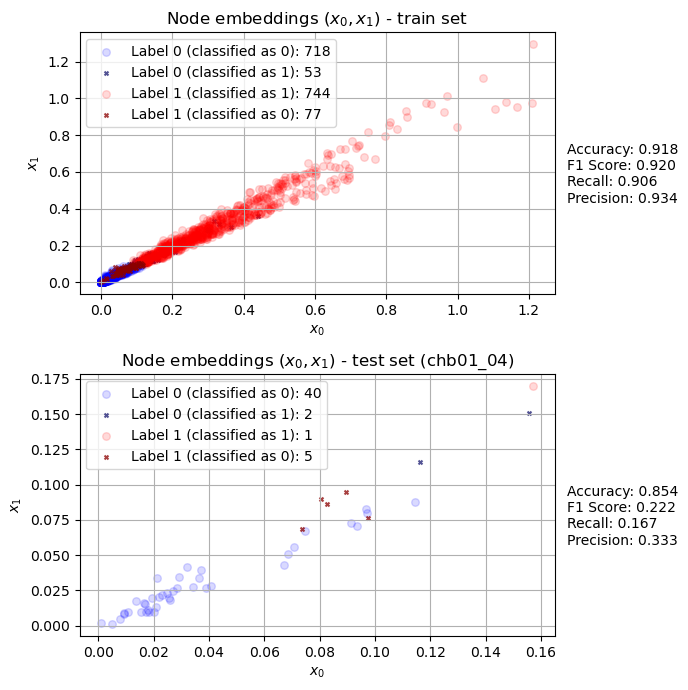

In [24]:
if ('Torch' in eval_manager._evaluators[0]._oracle.name) or ('GCN' in eval_manager._evaluators[0]._oracle.name):
    fig, ax = plt.subplots(2, figsize=(7,7))
    ax[0] = plot_embeddings_with_metrics(all_embeddings, f'Node embeddings $(x_0,x_1)$ - train set', ax=ax[0])
    ax[1] = plot_embeddings_with_metrics(test_embeddings, f"Node embeddings $(x_0,x_1)$ - test set{' (' + patient_id + '_' + record_id + ')' if patient_id != '' else ''}", ax=ax[1])
    plt.tight_layout()

    plt.savefig(f"{embeddings_path}{file_name.split('-')[0]}_{patient_id}_{record_id}.png", bbox_inches='tight')
    plt.show()
else:
    print("-->> Train set")
    print_metrics(all_embeddings)

    print(f"\n-->> Test set{' (' + patient_id + '_' + record_id + ')' if patient_id != '' else ''}")
    print_metrics(test_embeddings)

In [25]:
print("-->> Train set")
print_metrics(all_embeddings)

print(f"\n-->> Test set{' (' + patient_id + '_' + record_id + ')' if patient_id != '' else ''}")
print_metrics(test_embeddings)

-->> Train set
       Accuracy: 0.918
       F1 Score: 0.920
       Recall: 0.906
       Precision: 0.934

       Label 0 (classified as 0): 718
       Label 0 (classified as 1): 53
       Label 1 (classified as 1): 744
       Label 1 (classified as 0): 77

-->> Test set (chb01_04)
       Accuracy: 0.854
       F1 Score: 0.222
       Recall: 0.167
       Precision: 0.333

       Label 0 (classified as 0): 40
       Label 0 (classified as 1): 2
       Label 1 (classified as 1): 1
       Label 1 (classified as 0): 5


## _______________________________________________________________

In [26]:
import datetime

now = datetime.datetime.now()
print("Last full run:", now.strftime("%d/%m/%Y, ore %H:%M"))

Last full run: 20/06/2025, ore 15:00
